# Install & Import packages

In [1]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Union

from huggingface_hub import notebook_login
import evaluate
from datasets import load_dataset
from dataclasses import dataclass

import tensorflow as tf
from transformers import AutoTokenizer, create_optimizer, TFAutoModelForMultipleChoice
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers.keras_callbacks import EarlyStopping, KerasMetricCallback, PushToHubCallback

# Download dataset

In [3]:
# Login into HuggingFace hub for models management
notebook_login()

Download medmcqa dataset from huggingface hub

In [4]:
# We only use 8000 training examples and 1000 validation examples for this project
train_ds = load_dataset("medmcqa", split="train[:8000]")
validation_ds = load_dataset("medmcqa", split="validation[:1000]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

# Explore dataset

In [ ]:
df = train_ds.to_pandas()
df.head()

Check to see if there are multiple-answered question

In [ ]:
# multi type question only has one correct answer that is similar to single type question in this dataset
multi = df[df['choice_type'] == 'multi']
multi.head()

,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
2,5c38bea6-787a-44a9-b2df-88f4218ab914,All of the following are surgical options for ...,Adjustable gastric banding,Biliopancreatic diversion,Duodenal Switch,Roux en Y Duodenal By pass,3,multi,"Ans. is 'd' i.e., Roux en Y Duodenal Bypass Ba...",Surgery,Surgical Treatment Obesity
3,cdeedb04-fbe9-432c-937c-d53ac24475de,Following endaerectomy on the right common car...,Central aery of the retina,Infraorbital aery,Lacrimal aery,Nasociliary aretry,0,multi,The central aery of the retina is a branch of ...,Ophthalmology,None
6,a83de6e4-9427-4480-b404-d96621ebb640,Abnormal vascular patterns seen with colposcop...,Punctation,Mosaicism,Satellite lesions,Atypical vessels,2,multi,"Abnormal vascular pattern include punctation, ...",Gynaecology & Obstetrics,None
11,e529be7c-f360-4dba-b313-7f3fc240697a,Which of the following statements are True/Fal...,"1, 2, 3 True & 4, 5 false","1, 3, 5 True & 2, 4 false","2, 4, 5 True & 1, 3 false","1, 2, 3, 4 True & 5 false",2,multi,Here statement 1 & 3 are wrong. It is actually...,Medicine,None
13,d64eabcf-da66-438f-a53f-7137d3bba9dd,True regarding lag phase is?,Time taken to adpt in the new environment,Growth occurs exponentially,The plateau in lag phase is due to cell death,It is the 2nd phase in bacterial growth curve,0,multi,Lag phase: Immediately following the seeding o...,Microbiology,general microbiology


# Prepare the dataset for fine-tuning

As choices are stored in different features, we need to concatinate them with their questions as text input into the training model

In [5]:
def concat_questions_with_choices(example):
  example["question"] = """
  {question}.

  Please select one of the following questions:
  A. {opa}
  B. {opb}
  C. {opc}
  D. {opd}

  The answer is
  """.format(
      question=example["question"],
      opa=example["opa"],
      opb=example["opb"],
      opc=example["opc"],
      opd=example["opd"]
  )

  return example

In [6]:
train_ds = train_ds.map(concat_questions_with_choices)
validation_ds = validation_ds.map(concat_questions_with_choices)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
# Rename 'cop' column name to 'label'
train_ds = train_ds.rename_column("cop", "label")
validation_ds = validation_ds.rename_column("cop", "label")

Choose pre-trained model checkpoint for fine-tuning

In [28]:
# For this project, we consider three model checkpoints:
# 1. distilbert/distilbert-base-uncased
# 2. google/mobilebert-uncased
# 3. Intel/dynamic_tinybert
# Choose one checkpoint for fine-tuning
model_name = "Intel/dynamic_tinybert"

Choose the correct tokenizer for the training model

In [29]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenize questions and answers

In [30]:
op_keys = ["opa", "opb", "opc", "opd"]

def preprocess_function(examples):

    questions = [[question] * 4 for question in examples["question"]]
    answers = [[examples[key][i] for key in op_keys] for i, _ in enumerate(examples["question"])]

    questions = sum(questions, [])
    answers = sum(answers, [])

    tokenized_examples = tokenizer(questions, answers, truncation=True)
    return {k: [v[i : i + 4] for i in range(0, len(v), 4)] for k, v in tokenized_examples.items()}

In [31]:
tokenized_train_dataset = train_ds.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Inspect dataset features following tokenization

In [ ]:
tokenized_train_dataset.features

{'id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'opa': Value(dtype='string', id=None),
 'opb': Value(dtype='string', id=None),
 'opc': Value(dtype='string', id=None),
 'opd': Value(dtype='string', id=None),
 'label': ClassLabel(names=['a', 'b', 'c', 'd'], id=None),
 'choice_type': Value(dtype='string', id=None),
 'exp': Value(dtype='string', id=None),
 'subject_name': Value(dtype='string', id=None),
 'topic_name': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

As transformers does not have a data collator for multiple choice, we'll need to use DataCollatorWithPadding to create a batch of examples. In this process, sentences are dynamically padded to the longest length in their batch. It's more efficient than padding to the maximum length in the dataset.

In [32]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="tf",
        )

        batch = {k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()}
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int64)
        return batch

In [ ]:
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

We use evaluate library to assess the model's performance during training and testing

In [33]:
accuracy = evaluate.load("accuracy")

In [34]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Set up an optimizer for the model with batch size, number of training epochs and learning rate.

In [35]:
batch_size = 16
num_train_epochs = 10
total_train_steps = (len(train_ds) // batch_size) * num_train_epochs
optimizer, schedule = create_optimizer(init_lr=5e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

# Download pre-trained model

Load the model from HuggingFace model hub

In [36]:
model = TFAutoModelForMultipleChoice.from_pretrained(model_name, from_pt=True)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMultipleChoice: ['fit_dense.weight', 'qa_outputs.bias', 'qa_outputs.weight', 'bert.embeddings.position_ids', 'fit_dense.bias']
- This IS expected if you are initializing TFBertForMultipleChoice from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMultipleChoice from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForMultipleChoice were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

Model: "tf_bert_for_multiple_choice_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  66955008  
                                                                 
 dropout_77 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 66955777 (255.42 MB)
Trainable params: 66955777 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Convert the tokenized dataset to tf.data.Dataset format.

In [38]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_validation_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Compile the model

In [39]:
model.compile(optimizer=optimizer)

Configure metrics callback

In [40]:
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=tf_validation_set
    )

Configure early stopping mechanism to stop training the model after 2 epochs of insignificant decrease in loss

In [41]:
early_stopping_cb = EarlyStopping(
    monitor='loss',
    patience=2,
    verbose=1,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=1
)

In [43]:
output_dir_huggingface_hub = "medmcqa-{}".format(model_name)

push_to_hub_callback = PushToHubCallback(
    output_dir=output_dir_huggingface_hub,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/hoangtran0308/medmcqa-tiny-bert into local empty directory.


In [44]:
callbacks = [early_stopping_cb, metric_callback, push_to_hub_callback]

In [46]:
history = model.fit(
    x=tf_train_set,
    validation_data=tf_validation_set,
    epochs=10,
    callbacks=callbacks
    )

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.3858

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 246s 493ms/step - loss: 1.3858 - val_loss: 1.3862 - accuracy: 0.3290
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 1.3878

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 235s 471ms/step - loss: 1.3878 - val_loss: 1.3850 - accuracy: 0.3210
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 1.3784

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 239s 478ms/step - loss: 1.3784 - val_loss: 1.3869 - accuracy: 0.3180
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 1.3172

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 240s 481ms/step - loss: 1.3172 - val_loss: 1.3945 - accuracy: 0.3300
Epoch 5/10
500/500 [==============================] - ETA: 0s - loss: 1.1564

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 245s 491ms/step - loss: 1.1564 - val_loss: 1.5962 - accuracy: 0.3070
Epoch 6/10
500/500 [==============================] - ETA: 0s - loss: 0.9487

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 220s 440ms/step - loss: 0.9487 - val_loss: 1.6876 - accuracy: 0.2950
Epoch 7/10
500/500 [==============================] - ETA: 0s - loss: 0.7610

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 232s 465ms/step - loss: 0.7610 - val_loss: 2.1023 - accuracy: 0.2900
Epoch 8/10
500/500 [==============================] - ETA: 0s - loss: 0.6154

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 242s 484ms/step - loss: 0.6154 - val_loss: 2.5488 - accuracy: 0.2890
Epoch 9/10
500/500 [==============================] - ETA: 0s - loss: 0.5057

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 241s 482ms/step - loss: 0.5057 - val_loss: 2.8837 - accuracy: 0.2920
Epoch 10/10
500/500 [==============================] - ETA: 0s - loss: 0.4325

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


500/500 [==============================] - 229s 459ms/step - loss: 0.4325 - val_loss: 3.1445 - accuracy: 0.2930


Visualize training and validation loss during model training 

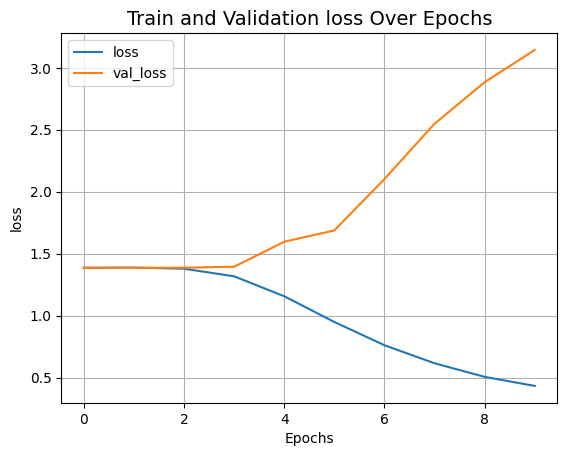

In [47]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")

Commit model checkpoint to HuggingFace Hub for future access

In [48]:
model.push_to_hub(output_dir_huggingface_hub)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard_data.py:322: UserWarning: Invalid model-index. Not loading eval results into CardData.
  warnings.warn("Invalid model-index. Not loading eval results into CardData.")


# Evaluate model on test dataset

In [15]:
# Download fine-tuned model from my model hub
# The models are hosted at
# 1. hoangtran0308/medmcqa-distil-bert-based-uncased
# 2. hoangtran0308/medmcqa-mobile-bert-uncased
# 3. hoangtran0308/medmcqa-tiny-bert
# Choose one model for evaluation
model = TFAutoModelForMultipleChoice.from_pretrained("hoangtran0308/medmcqa-distil-bert-based-uncased")

config.json:   0%|          | 0.00/530 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at hoangtran0308/medmcqa-distil-bert-based-uncased were not used when initializing TFDistilBertForMultipleChoice: ['dropout_99']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at hoangtran0308/medmcqa-distil-bert-based-uncased and are newly initialized: ['dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prepare test dataset

In [49]:
# We use a subset of validation dataset for testing. The models were validated with first 1000 examples, hence we use the subsequent subset.
test_ds = load_dataset("medmcqa", split="validation[1000:2000]")

In [50]:
# Prepare the test dataset
test_ds = test_ds.rename_columns({
    "cop": "label"
})

tokenized_test_dataset = test_ds.map(concat_questions_with_choices).map(preprocess_function, batched=True)

tf_test_set = model.prepare_tf_dataset(
    tokenized_test_dataset,
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Get the prediction

In [53]:
p = model.predict(tf_test_set)
p.logits

32/32 [==============================] - 17s 465ms/step


In [55]:
predictions = list(np.argmax(p.logits, axis=1))
labels = tokenized_test_dataset["label"]

Calculate the model accuracy on test dataset 

In [56]:
accuracy = evaluate.load("accuracy")
metric = accuracy.compute(predictions=predictions, references=labels)
print("Model accuracy on test dataset is {:.2f}%".format(metric["accuracy"]*100))

Model accuracy on test dataset is 29.20%


Calculate the precision, recall and F1-Score from confusion matrix

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, predictions)

_labels = ["a", "b", "c", "d"]  # Assumes your labels are numeric
print("Confusion Matrix:")
print('     ', end='')
for label in _labels:
    print(f'{label:^7}', end='')  # Center column headers
print()
for i, row in enumerate(cm):
    print(f'{_labels[i]:^5}', end='')  # Print the true label index
    for value in row:
        print(f'{value:^7}', end='')
    print()

Confusion Matrix:
        a      b      c      d   
  a    113    71     70     50   
  b    84     81     50     50   
  c    78     60     58     38   
  d    66     41     50     40   


In [58]:
def calculate_metrics(cm):
    """Calculates precision, recall, and F1-score from a confusion matrix."""
    precision = []
    recall = []
    f1 = []
    for i in range(len(cm)):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        precision.append(TP / (TP + FP))
        recall.append(TP / (TP + FN))
        f1.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))

    return precision, recall, f1

In [59]:
# Calculate metrics
precision, recall, f1 = calculate_metrics(cm)

# Print results with labels
labels = np.unique(_labels)  # Assumes your labels are numeric
for i, label in enumerate(labels):
    print(f"Metrics for Class {label}:")
    print(f"Precision: {precision[i]:.3f}")
    print(f"Recall: {recall[i]:.3f}")
    print(f"F1-Score: {f1[i]:.3f}")
    print("-------")

# Macro-averages (optional)
print("Macro-Averaged Metrics:")
print(f"Precision (Macro): {np.mean(precision):.3f}")
print(f"Recall (Macro): {np.mean(recall):.3f}")
print(f"F1-Score (Macro): {np.mean(f1):.3f}")

Metrics for Class a:
Precision: 0.331
Recall: 0.372
F1-Score: 0.350
-------
Metrics for Class b:
Precision: 0.320
Recall: 0.306
F1-Score: 0.313
-------
Metrics for Class c:
Precision: 0.254
Recall: 0.248
F1-Score: 0.251
-------
Metrics for Class d:
Precision: 0.225
Recall: 0.203
F1-Score: 0.213
-------
Macro-Averaged Metrics:
Precision (Macro): 0.283
Recall (Macro): 0.282
F1-Score (Macro): 0.282
